In [24]:
import pandas as pd
from fastai.text.all import *
from os.path import exists
import re
import csv
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import math
import sys, os
from pathlib import Path
csv.field_size_limit(2147483647)

2147483647

### Functions

In [25]:
# Training and testing datasets
df_train = pd.read_csv("data/designs-train.csv", sep="‡", engine="python", index_col="id")
df_test = pd.read_csv("data/designs-test.csv", sep="‡", engine="python", index_col="id")

In [26]:
# Constructs dataloaders (dataset arrangement in batches, used for fastai model training)
# Note: If training crashes due to full CUDA memory, decrease the batch size (bs) value; however, this will alter the training results.
# Monitoring GPU usage while training (in terminal): gpustat --watch
def make_dls(df, text_cols):
    with io.capture_output() as captured:
        classifier = DataBlock(blocks=(TextBlock.from_df(text_cols=text_cols), CategoryBlock),
                            n_inp=1,
                            get_x=ColReader('text'),
                            splitter=ColSplitter(col='is_valid'),
                            get_y=[ColReader('category')])
        dataloaders = classifier.dataloaders(df, bs=128)
    return dataloaders

In [27]:
# Sets all randomization seeds to a specific value for replicable results
def set_seed(dls, x=42):
    random.seed(x)
    dls.rng.seed(x)
    np.random.seed(x)
    torch.manual_seed(x)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    if torch.cuda.is_available(): torch.cuda.manual_seed_all(x)

In [28]:
# Accuracy and loss functions
def category_accuracy(inp, category): return accuracy(inp, category)
def category_loss(inp, category): return CrossEntropyLossFlat()(inp, category)

In [29]:
# Gets category predictions from a model and a given dataset
def get_preds(model, df, text_cols):
    with io.capture_output() as captured:
        df_probs = tokenize_df(df=df, text_cols=text_cols, tok=model.dls.tok)[0]
        dl = model.dls.test_dl(df_probs)
        with model.no_logging(), model.no_bar(): probs, _ = model.get_preds(dl=dl)
        probs = torch.sigmoid(probs)
        return [dict(zip(model.dls.vocab[1], p)) for p in probs]

In [30]:
# Checking accuracy in a specific df
def check_accuracy(model, df, text_cols):
    preds = get_preds(model, df, text_cols)
    x = tensor([list(p.values()) for p in preds])
    y = tensor(model.dls.vocab[1].map_objs(df["category"]))
    return category_accuracy(x, y)

In [31]:
# Reclassifies a part of the dataset based on prediction confidence and trust
def reclassify(model, df, text_cols, p=0.01, t=0.5):
    df_t = df.loc[df["is_valid"] == 0].copy()
    preds = get_preds(model, df_t, text_cols)
    
    df_t["prob"] = [max(p.values()) for p in preds]
    df_t["pred"] = [max(p, key=p.get) for p in preds]
    df_t["wrong"] = df_t["category"] != df_t["pred"]
    
    count = math.ceil(p*len(df_t))
    df_t.loc[df_t["wrong"], "sort_val"] = df_t.apply(lambda x: x["prob"] - t * x["trust"], axis=1)
    idx = df_t.loc[df_t["wrong"]].sort_values(by=['sort_val'], ascending=False).iloc[0:count].index

    df_new = df.copy()
    changes_log = [""]
    changes_log += [f"changed category of {i}: {df_new.loc[i, 'category']} -> {df_t.loc[i, 'pred']}" for i in idx]
    df_new.loc[idx, "category"] = df_t.loc[idx, "pred"]
    return df_new, changes_log

In [32]:
# Loads a model if a saved one exists, otherwise trains a new one
def load_or_create(df, path='', text_cols=['long_description', 'page_title', 'page_body', 'meta_title', 'meta_description'], epochs=10, mode=1, delay=2, p=0.01, t=0.5):
    torch.cuda.empty_cache()
    # If a saved model exists, load it
    if path and exists(path+f'{mode}model.pkl'):
        return (load_pickle(path + f'{mode}model.pkl'),
                load_pickle(path + f'{mode}metrics.pkl'),
                pd.read_csv(path + f'{mode}data.csv', sep='‡', engine='python', index_col='id'))
    else:
        dls = make_dls(df, text_cols)
        df_new = df.copy()
        set_seed(dls)
        learner = text_classifier_learner(dls, AWD_LSTM, drop_mult=0.5, loss_func=category_loss, metrics=[category_accuracy]).to_fp16()
        metrics = []
        changes_log = []
        # Iterative Reclassification
        for i in tqdm(range(epochs)):
            # Training for 1 epoch
            with learner.no_bar(), learner.no_logging():
                learner.fit_one_cycle(1)
            # Tracking metrics: train loss, valid loss, valid accuracy, test accuracy
            metrics.append((learner.recorder.losses[-1],
                            learner.recorder.loss.value,
                            learner.recorder.metrics[0].value,
                            check_accuracy(learner, df_test, text_cols)
                            ))
            # Reclassification
            if mode == 1 and delay <= i:
                df_new, changes = reclassify(learner, df_new, text_cols, t=t, p=p)
                changes_log += changes
                learner.dls = make_dls(df_new, text_cols)

        #  Saving the model, metrics and modified dataset
        if path:
            Path(path).mkdir(parents=True, exist_ok=True)
            save_pickle(path + f'{mode}model.pkl', learner)
            save_pickle(path + f'{mode}metrics.pkl', metrics)
            df_new.to_csv(path + f'{mode}data.csv', sep="‡")
            if mode != 0:
                f = open(path + f'{mode}changes.log', 'w')
                for line in changes_log:
                    f.write(f"{line}\n")
                f.close()
        torch.cuda.empty_cache()
        return learner, metrics, df_new


In [33]:
# Comparing the metrics of different models
def plotMetrics(labels, metricsList, delay=0):
    xlabel="epoch"
    ylabels=["training loss", "validation loss", "validation accuracy", "test accuracy"] 
    for col in range(4):
        for i in range(len(labels)):
            plt.plot([x[col] for x in metricsList[i]], label=labels[i])
        plt.ylabel(ylabels[col])
        plt.xlabel(xlabel)
        plt.legend()
        if delay != 0: plt.axvline(x = delay, color = "grey", linestyle=":")
        plt.show()

In [34]:
# Comparing avg and max accuracies
def compareAccuracy(labels, metricsList):
    df_accuracy = pd.DataFrame()
    df_accuracy["model"] = labels
    df_accuracy["max valid accuracy"] = [np.round(max([x[2] for x in metrics]).numpy(), 3) for metrics in metricsList]
    df_accuracy["max test accuracy"] = [np.round(max([x[3] for x in metrics]).numpy(), 3) for metrics in metricsList]
    df_accuracy["max combined accuracy"] = [np.round(max([x[2] + x[3] for x in metrics]).numpy() / 2, 3) for metrics in metricsList]
    return df_accuracy

### Iterative reclassification testing

In [35]:
_, metrics1, df1 = load_or_create(df_train, path="models/ir/cat/1/", text_cols=["long_description"], epochs=50, mode=0)

In [36]:
_, metrics2_005, df2_005 = load_or_create(df_train, path="models/ir/cat/2_005/", text_cols=["long_description"], epochs=50, mode=1, p=0.005, t=0)
_, metrics2_01,  df2_01  = load_or_create(df_train, path="models/ir/cat/2_01/",  text_cols=["long_description"], epochs=50, mode=1, p=0.01,  t=0)
_, metrics2_02,  df2_02  = load_or_create(df_train, path="models/ir/cat/2_02/",  text_cols=["long_description"], epochs=50, mode=1, p=0.02,  t=0)
_, metrics3_005, df3_005 = load_or_create(df_train, path="models/ir/cat/3_005/", text_cols=["long_description"], epochs=50, mode=1, p=0.005, t=0.5)
_, metrics3_01,  df3_01  = load_or_create(df_train, path="models/ir/cat/3_01/",  text_cols=["long_description"], epochs=50, mode=1, p=0.01,  t=0.5)
_, metrics3_02,  df3_02  = load_or_create(df_train, path="models/ir/cat/3_02/",  text_cols=["long_description"], epochs=50, mode=1, p=0.02,  t=0.5)

In [37]:
_, metrics4_01, df4_01 = load_or_create(df_train, path="models/ir/cat/4_01/", text_cols=["long_description"], epochs=50, mode=1, delay=10, p=0.01, t=0)
_, metrics4_05, df4_05 = load_or_create(df_train, path="models/ir/cat/4_05/", text_cols=["long_description"], epochs=50, mode=1, delay=10, p=0.05, t=0)
_, metrics5_01, df5_01 = load_or_create(df_train, path="models/ir/cat/5_01/", text_cols=["long_description"], epochs=50, mode=1, delay=10, p=0.01, t=0.5)
_, metrics5_05, df5_05 = load_or_create(df_train, path="models/ir/cat/5_05/", text_cols=["long_description"], epochs=50, mode=1, delay=10, p=0.05, t=0.5)

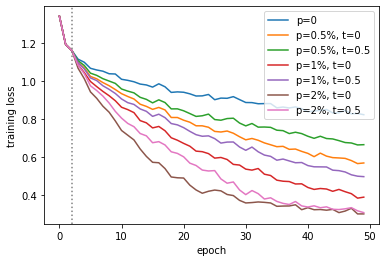

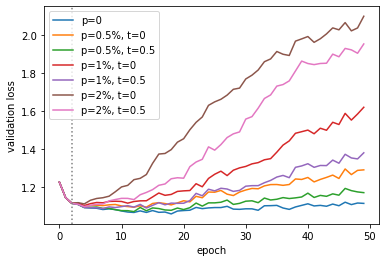

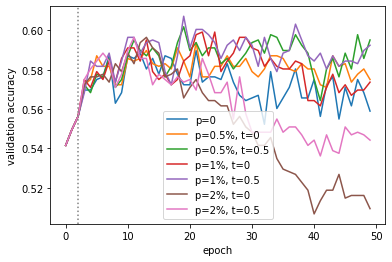

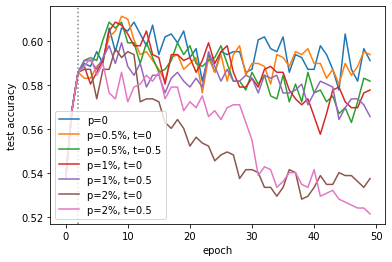

In [38]:
plotMetrics(["p=0", "p=0.5%, t=0", "p=0.5%, t=0.5", "p=1%, t=0", "p=1%, t=0.5", "p=2%, t=0", "p=2%, t=0.5"], 
            [metrics1, metrics2_005, metrics3_005, metrics2_01, metrics3_01, metrics2_02, metrics3_02], delay=2)

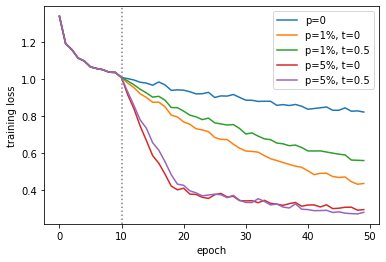

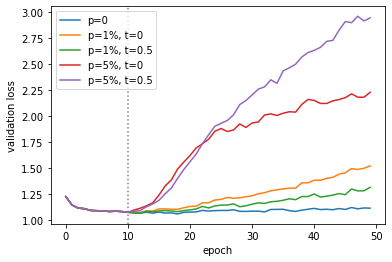

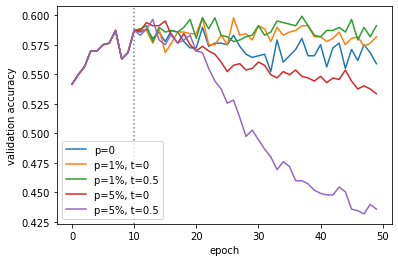

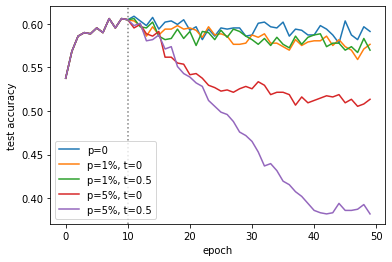

In [39]:
plotMetrics(["p=0", "p=1%, t=0", "p=1%, t=0.5", "p=5%, t=0", "p=5%, t=0.5"], 
            [metrics1, metrics4_01, metrics5_01, metrics4_05, metrics5_05], delay=10)

In [40]:
compareAccuracy(["1", "2_005", "2_01", "2_02", "3_005", "3_01", "3_02", "4_01", "4_05", "5_01", "5_05"], 
                [metrics1, metrics2_005, metrics2_01, metrics2_02, metrics3_005, metrics3_01, metrics3_02, metrics4_01, metrics4_05, metrics5_01, metrics5_05])

,model,max valid accuracy,max test accuracy,max combined accuracy
0,1,0.590,0.609,0.597
1,2_005,0.594,0.611,0.598
2,2_01,0.599,0.609,0.600
3,2_02,0.597,0.597,0.592
4,3_005,0.602,0.609,0.598
5,3_01,0.607,0.599,0.597
6,3_02,0.597,0.592,0.589
7,4_01,0.598,0.606,0.597
8,4_05,0.595,0.606,0.597
9,5_01,0.599,0.606,0.597


### Web scraping testing

In [41]:
df_test["long_description"] = ""

In [42]:
_, metrics1_web, _ = load_or_create(df_train, path="models/web/cat/1/", text_cols=["long_description"], epochs=50, mode=0)
_, metrics2_web, _ = load_or_create(df_train, path="models/web/cat/2/", text_cols=["page_title", "page_body", "meta_title", "meta_description"], epochs=50, mode=0)
_, metrics3_web, _ = load_or_create(df_train, path="models/web/cat/3/", text_cols=["long_description", "page_title", "page_body", "meta_title", "meta_description"], epochs=50, mode=0)

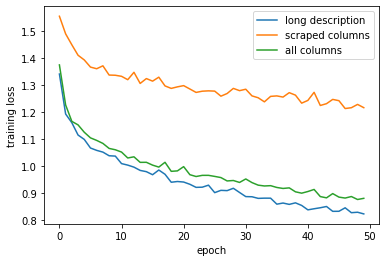

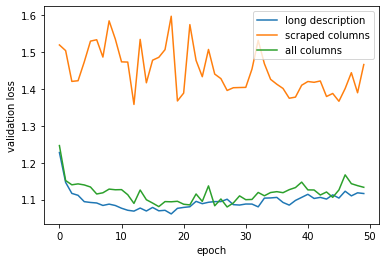

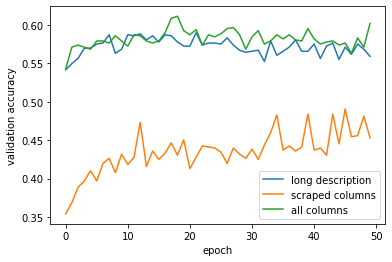

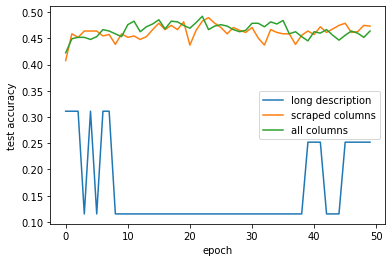

In [43]:
plotMetrics(["long description", "scraped columns", "all columns"], [metrics1_web, metrics2_web, metrics3_web])

In [44]:
compareAccuracy(["long description", "scraped columns", "all columns"], [metrics1_web, metrics2_web, metrics3_web])

,model,max valid accuracy,max test accuracy,max combined accuracy
0,long description,0.590,0.311,0.449
1,scraped columns,0.491,0.489,0.485
2,all columns,0.611,0.492,0.546
